# Solid Angle Computation

This notebook explores a new method to compute solid angles for arbitrary WCS transformations. For this method the pixels are split into two spherical triangles.
The areas of these triangles are then computed using https://en.wikipedia.org/wiki/Spherical_trigonometry#Area_and_spherical_excess

The new method is more precise for projections, where strong distortions of pixels occured, such as the AIT porjection. This check also revealed an un-noticed bug in the 
previous computation. Looking at the TAN projection exampled shown below, one can see an assymetry of the solid angles, which is not expected.

In [1]:
%matplotlib inline
import numpy as np
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from gammapy.maps import WcsGeom, MapAxis, Map
import matplotlib.pyplot as plt
from astropy.coordinates.angle_utilities import angular_separation, position_angle

In [2]:
def area_spherical_triangle_angle(a, b, C):
    """Compute the area of a spherical triangle.
    
    The formula is based on the spherical excess theorem, see 
    https://en.wikipedia.org/wiki/Spherical_trigonometry#Area_and_spherical_excess
    
    
    Parameters
    ----------
    a : `~numpy.ndarray`
        One side of the triangle.
    b : `~numpy.ndarray`
        Second side of the triangle.
    C : `~numpy.ndarray`
        Angle enclosed by a and b
        
    Returns
    -------
    area : `~numpy.ndarray`
        Area of the spherical triangle.
    """
    top = np.tan(0.5 * a) * np.tan(0.5 * b) * np.sin(C)
    bottom = 1 + np.tan(0.5 * a) * np.tan(0.5 * b) * np.cos(C)
    return 2 * np.arctan2(top, bottom)


def solid_angle(geom):
    coord = geom.get_coord(mode="edges").skycoord
    
    # define pixel corners
    low_left = coord[..., :-1, :-1]
    low_right = coord[..., 1:, :-1]
    up_left = coord[..., :-1, 1:]
    up_right = coord[..., 1:, 1:]
    
    # compute side lengths
    low = low_left.separation(low_right)
    left = low_left.separation(up_left)
    up = up_left.separation(up_right)
    right = low_right.separation(up_right)  
    
    # compute enclosed angles
    angle_low_right = low_right.position_angle(up_right) - low_right.position_angle(low_left)
    angle_up_left = up_left.position_angle(up_right) - low_left.position_angle(up_left)
    
    area_low_right = area_spherical_triangle_angle(low.rad, right.rad, angle_low_right.rad)
    area_up_left = area_spherical_triangle_angle(up.rad, left.rad, angle_up_left.rad)
    
    return u.Quantity(area_low_right + area_up_left, "sr", copy=False)

In [3]:
def compare(geom, vmin=0.1, vmax=1.1):
    plt.figure(figsize=(16, 5))
    sa_old = geom.solid_angle().to_value("deg2")
    
    with np.errstate(invalid="ignore"):
        sa_new = solid_angle(geom).to_value("deg2")
    
    ax_1 = plt.subplot(1, 2, 1, projection=geom.wcs)
    ax_2 = plt.subplot(1, 2, 2, projection=geom.wcs)
                         
    im = ax_1.imshow(sa_old, origin="lower", vmin=vmin, vmax=vmax)
    ax_1.grid()
    ax_1.set_title("Old")
    
    ax_2.imshow(sa_new, origin="lower", vmin=vmin, vmax=vmax)
    ax_2.grid()  
    ax_2.set_title("New")

# AIT Projection

In [4]:
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=1,
    width=(360, 180),
    coordsys='CEL',
    proj='AIT'
)

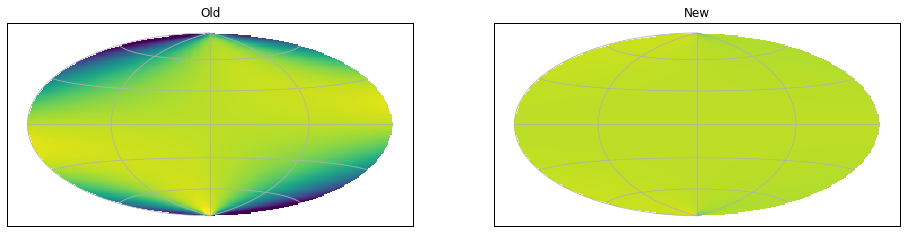

In [5]:
compare(geom)

# CAR Projection

In [6]:
geom_car = WcsGeom.create(
    skydir=(0, 0),
    binsz=1,
    width=(360, 180),
    coordsys='CEL',
    proj='CAR'
)

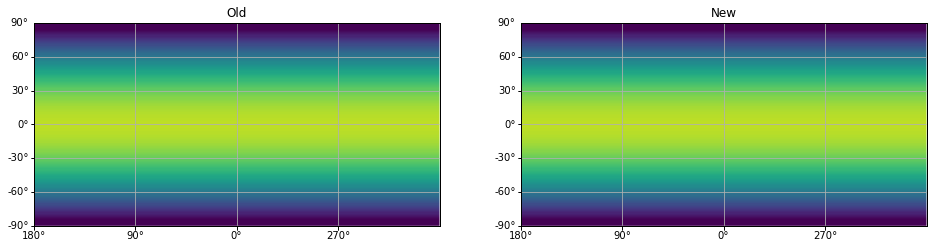

In [7]:
compare(geom_car)

# TAN Projection

In [8]:
geom_tan = WcsGeom.create(
    skydir=(0, 0),
    binsz=1,
    width=(360, 180),
    coordsys='CEL',
    proj='TAN'
)

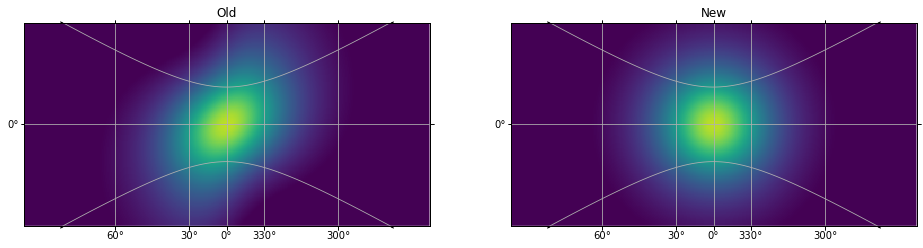

In [9]:
compare(geom_tan)

# MER Projection

In [10]:
geom_mer = WcsGeom.create(
    skydir=(0, 0),
    binsz=1,
    width=(360, 180),
    coordsys='CEL',
    proj='MOL'
)

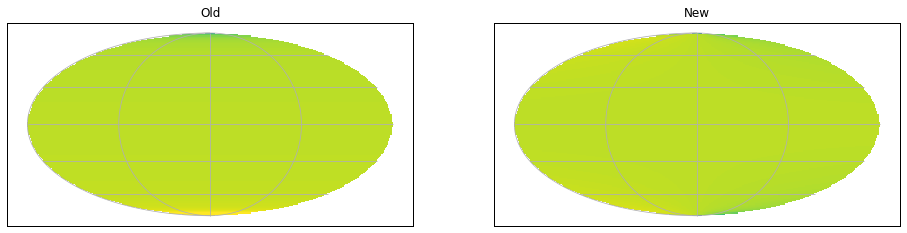

In [11]:
compare(geom_mer)

# Analysis Example

In [12]:
geom = WcsGeom.create(
    skydir=(228., -60),
    binsz=0.1,
    width=(5, 5),
    coordsys='CEL',
    proj='CAR'
)

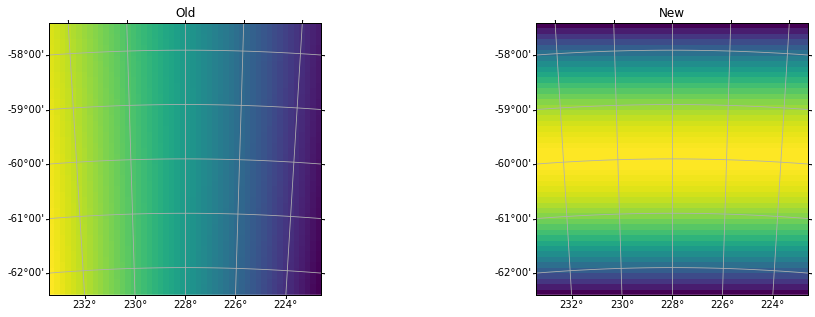

In [13]:
compare(geom, vmin=None, vmax=None)